In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# do autoreload
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import json
from names import get_names, get_names_dict
from plot_res import plot_all_results

In [3]:
def get_diameter(row):
    # return (row["w"]+row["h"]+row["d"])/3
    return min(row["w"], row["h"], row["d"])


def diameter_wise_clf(diameter):
    if diameter < 3:
        return "small"
    elif diameter >= 3 and diameter < 7:
        return "medium"
    else:
        return "large"


def read_json_metrics(json_file):
    json_file = str(json_file).replace("_EXT", "").replace("_TI", "")
    with open(json_file) as f:
        data = f.readlines()
        data = list(map(json.loads, data))

    columns = [
        "iteration",
        "cat_loss",
        "center_loss",
        "iou_loss",
        "size_loss",
        "total_loss",
    ]
    rows = []
    for datum in data:
        if "cat_loss" not in datum:
            continue
        row = [
            datum["iteration"],
            datum["cat_loss"],
            datum["center_loss"],
            datum["iou_loss"],
            datum["size_loss"],
            datum["total_loss"],
        ]
        rows.append(row)
    df = pd.DataFrame(rows, columns=columns)
    return df

In [4]:
columns = [
    "model",
    "viz_name",
    "chptk",
    "thr",
    "Se@FP0.5",
    "Se@FP1",
    "Se@FP2",
    "small_tpr",
    "medium_tpr",
    "large_tpr",
]
thrs = [0.2, 0.3, 0.4, 0.5]
chkpts = ["30k", "40k", "50k", "60k", "final"]

In [5]:
repo_root = Path("/home/ceballosarroyo.a/workspace/medical/cta-det2")
outputs_path = Path("/home/ceballosarroyo.a/workspace/medical/cta-det2/outputs")

rows = []

dict_metrics = {}

dict_nums_val = {"small": 17, "medium": 84, "large": 25}

dict_nums_train = {"small": 772, "medium": 329, "large": 258}

dict_nums_ext = {"small": 12, "medium": 64, "large": 25}
exp_names, viz_names = get_names()
dict_names = get_names_dict()
exp_names = dict_names.keys()
for i, exp_name in enumerate(exp_names):

    loss_file = outputs_path / f"{exp_name}/metrics.json"

    df_metrics = read_json_metrics(loss_file)
    dict_metrics[exp_name] = df_metrics
    for thr in thrs:
        all_inf_runs = (outputs_path / exp_name).glob(f"iou{str(thr)}_froc_*_crop")

        for run in all_inf_runs:
            if "EXT" in exp_name:
                path_test_annot = repo_root / "labels/external_0.4_crop.csv"
                dict_nums = dict_nums_ext
            elif not "TI" in exp_name:
                path_test_annot = (
                    repo_root / "labels/internal_test_crop_0.4.csv"
                    if "crop" in exp_name
                    else repo_root / "labels/test0.4.csv"
                )
                dict_nums = dict_nums_val
            else:
                path_test_annot = repo_root / "labels/train0.4_crop.csv"
                dict_nums = dict_nums_train
            df_annot = pd.read_csv(path_test_annot)
            # exp_path = outputs_path / f"{exp_name}/iou{str(thr)}_froc_{chpkt}_crop"
            exp_path = run
            chpkt_str = (
                exp_path.name.replace("iou0.5_froc_", "")
                .replace("_crop", "")
                .replace("iou0.1_froc_", "")
                .replace("iou0.2_froc_", "")
                .replace("iou0.3_froc_", "")
                .replace("iou0.4_froc_", "")
            )
            if "lr75" in exp_name:
                chpkt_str = chpkt_str.replace("final", "75k")
            else:
                chpkt_str = chpkt_str.replace("final", "68k")
            chpkt_int = 1000 * int(chpkt_str.replace("k", ""))
            df_results = pd.read_csv(exp_path / "froc.csv")
            sensitivities = df_results.iloc[0, 1:4].tolist()
            row = [exp_name, dict_names[exp_name], chpkt_int, thr] + sensitivities
            df_preds = pd.read_csv(exp_path / "model_detections.csv")
            df_annot["detected"] = df_preds["detected"]
            df_annot["diameter"] = df_annot.apply(get_diameter, axis=1)
            df_annot["size"] = df_annot["diameter"].apply(diameter_wise_clf)
            non_detect_counts = df_annot[df_annot["detected"] == False][
                "size"
            ].value_counts()
            non_detected_small = (
                non_detect_counts["small"] / dict_nums["small"]
                if "small" in non_detect_counts
                else 0
            )
            non_detected_medium = (
                non_detect_counts["medium"] / dict_nums["medium"]
                if "medium" in non_detect_counts
                else 0
            )
            non_detected_large = (
                non_detect_counts["large"] / dict_nums["large"]
                if "large" in non_detect_counts
                else 0
            )
            row = row + [
                1 - non_detected_small,
                1 - non_detected_medium,
                1 - non_detected_large,
            ]
            rows.append(row)

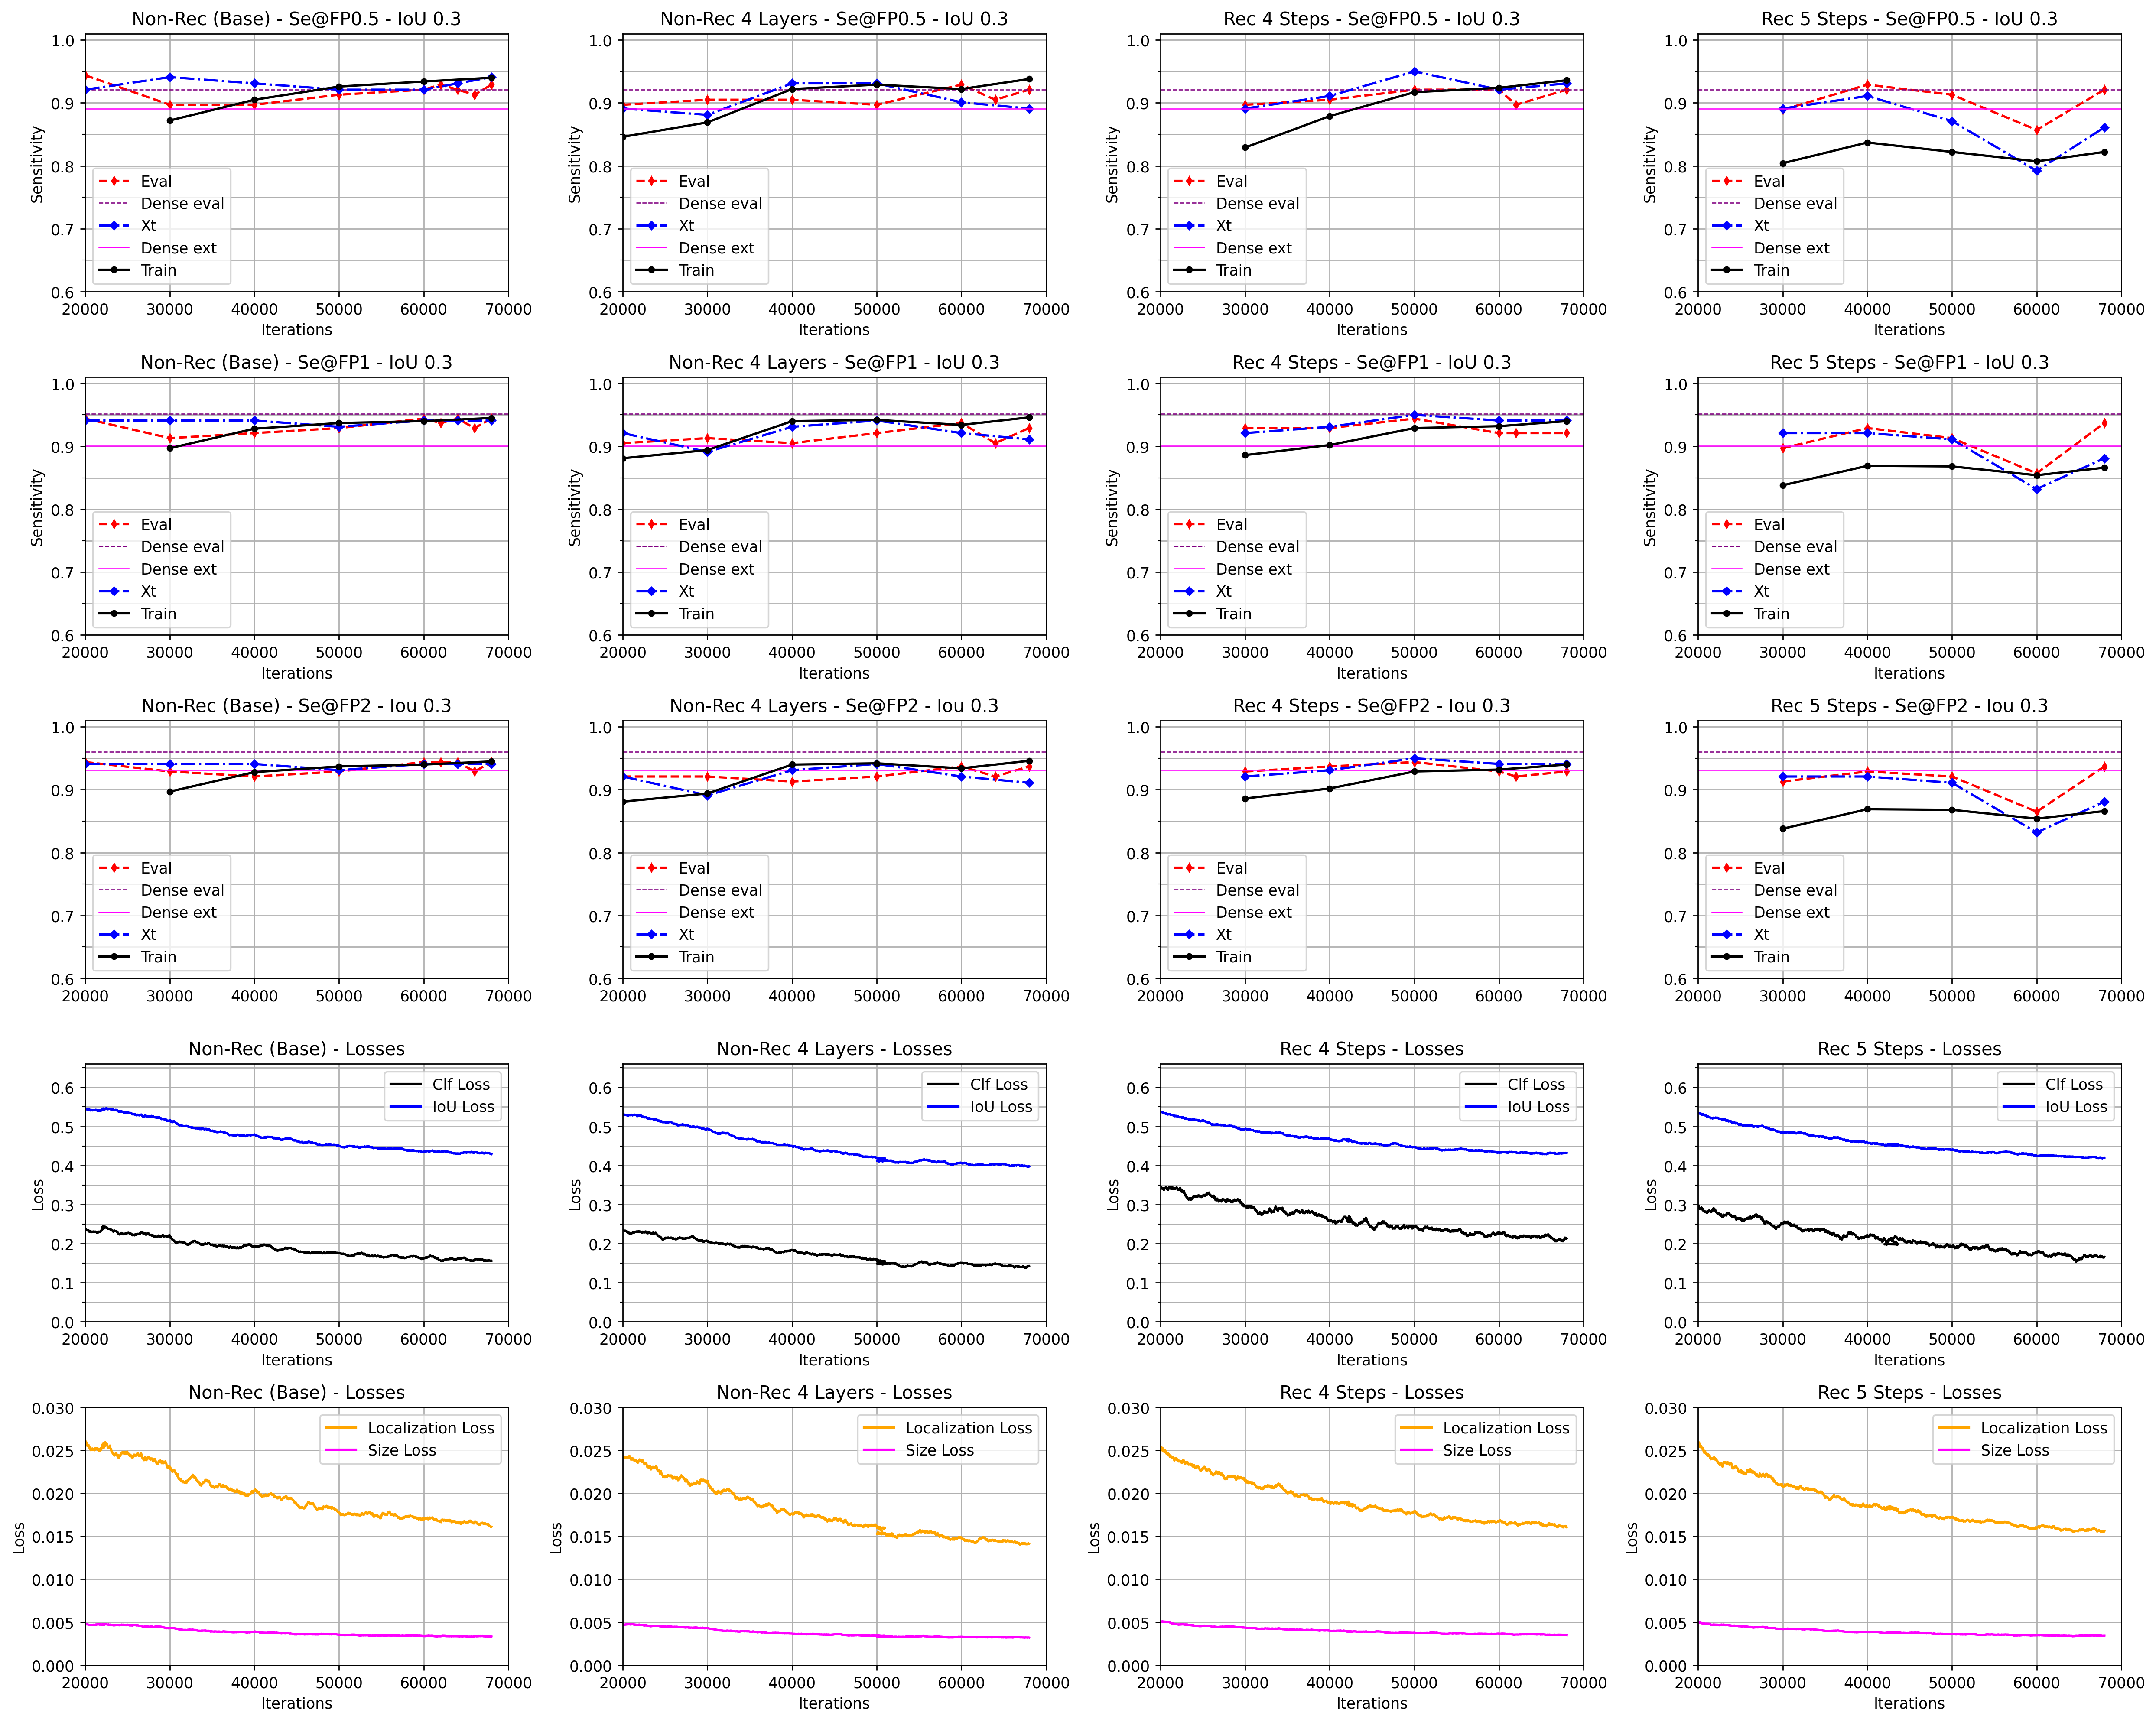

In [14]:
# for the given exp_name, plot one curve for each chekpoint
df_all = pd.DataFrame(rows, columns=columns)
iouthr = 0.3
df_all = df_all[df_all["thr"] == iouthr]
exp_is = [
    "deform_decoder_only_non_rec_BEST_cropinf",
    "deform_decoder_only_4_layers",
    "deform_decoder_only_rec_shared_step_lr_4_layers",
    "deform_decoder_only_rec_shared_step_lr_5_layers",
]
ti_versions = [exp + "_TI" for exp in exp_is]
ext_versions = [exp + "_EXT" for exp in exp_is]

plot_all_results(
    df_all,
    dict_metrics,
    exp_is,
    ti_versions,
    ext_versions,
    result_to_plot="Se",
    iouthr=iouthr,
)

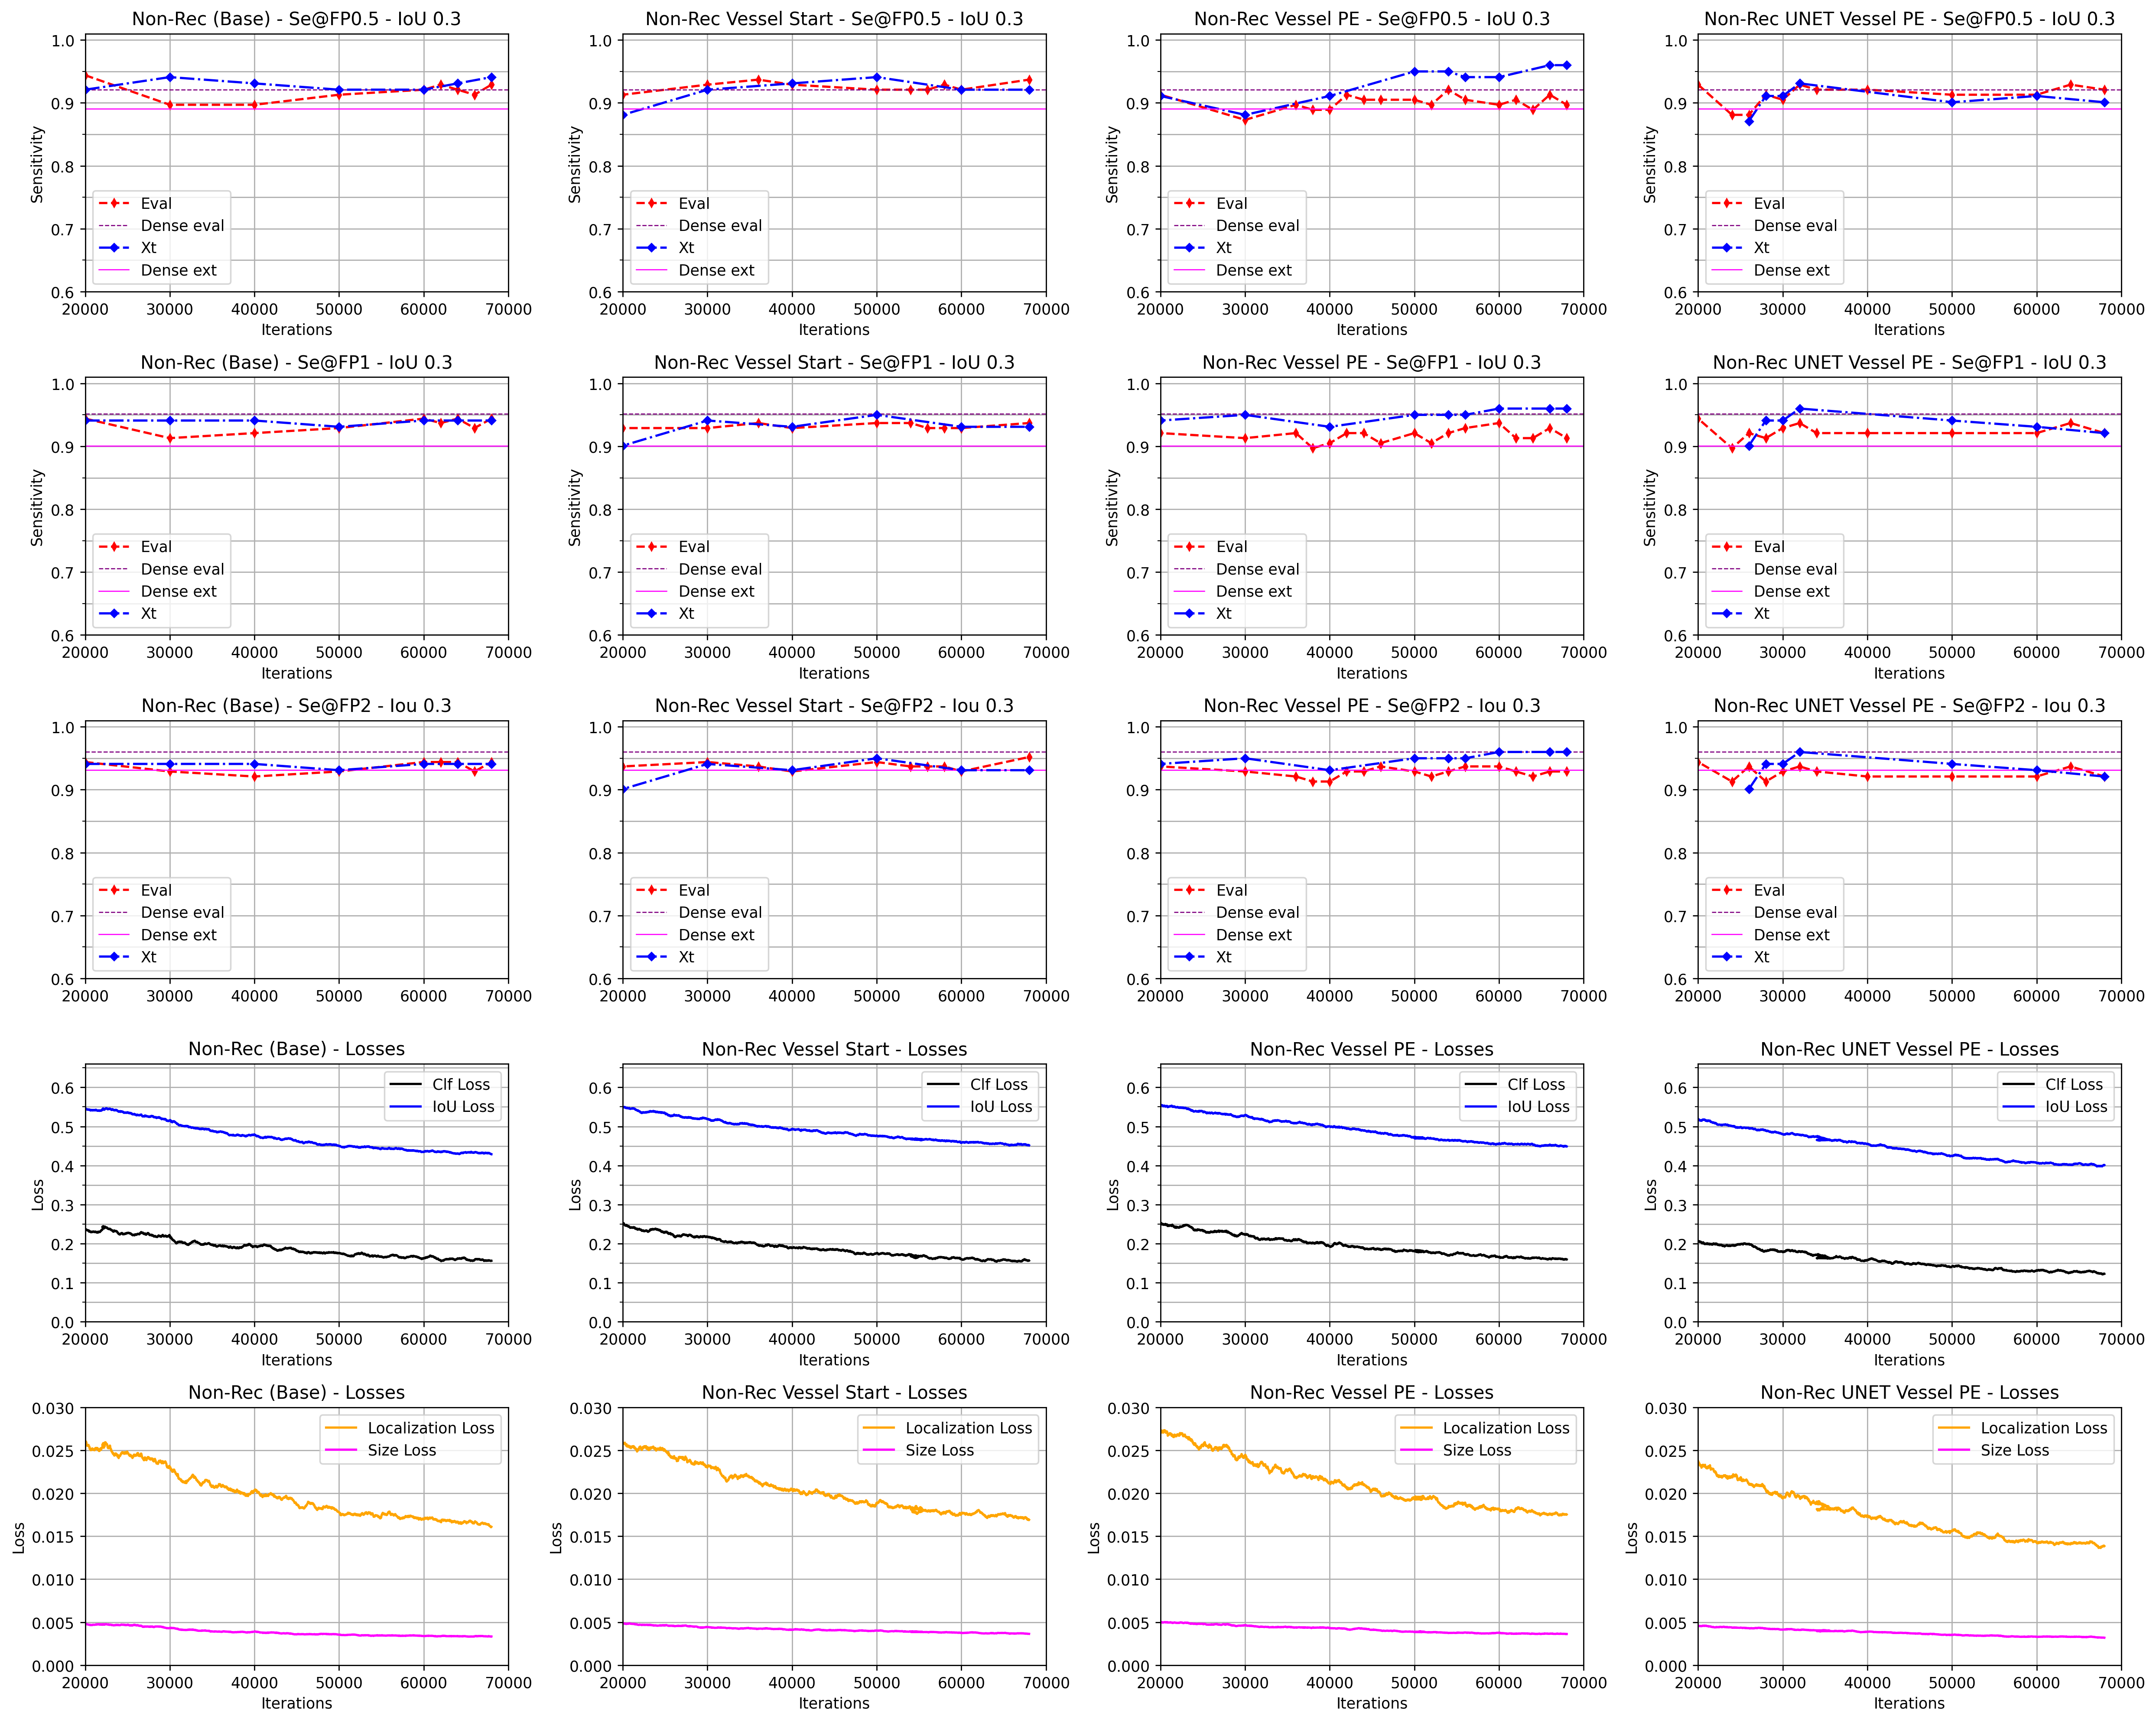

In [6]:
df_all = pd.DataFrame(rows, columns=columns)
iouthr = 0.3
df_all = df_all[df_all["thr"] == iouthr]
exp_is = [
    "deform_decoder_only_non_rec_BEST_cropinf",
    "adeform_decoder_only_non_rec_crop_vessel_start_gpe",
    "adeform_decoder_only_non_rec_crop_vessel_pe_gpe",
    "adeform_decoder_only_non_rec_crop_unet_vessel_pe_gpe",
]
ti_versions = []
ext_versions = [
    "deform_decoder_only_non_rec_BEST_cropinf_EXT",
    "adeform_decoder_only_non_rec_crop_vessel_start_gpe_EXT",
    "adeform_decoder_only_non_rec_crop_vessel_pe_gpe_EXT",
    "adeform_decoder_only_non_rec_crop_unet_vessel_pe_gpe_EXT",
]
plot_all_results(
    df_all,
    dict_metrics,
    exp_is,
    ti_versions,
    ext_versions,
    result_to_plot="Se",
    iouthr=iouthr,
)

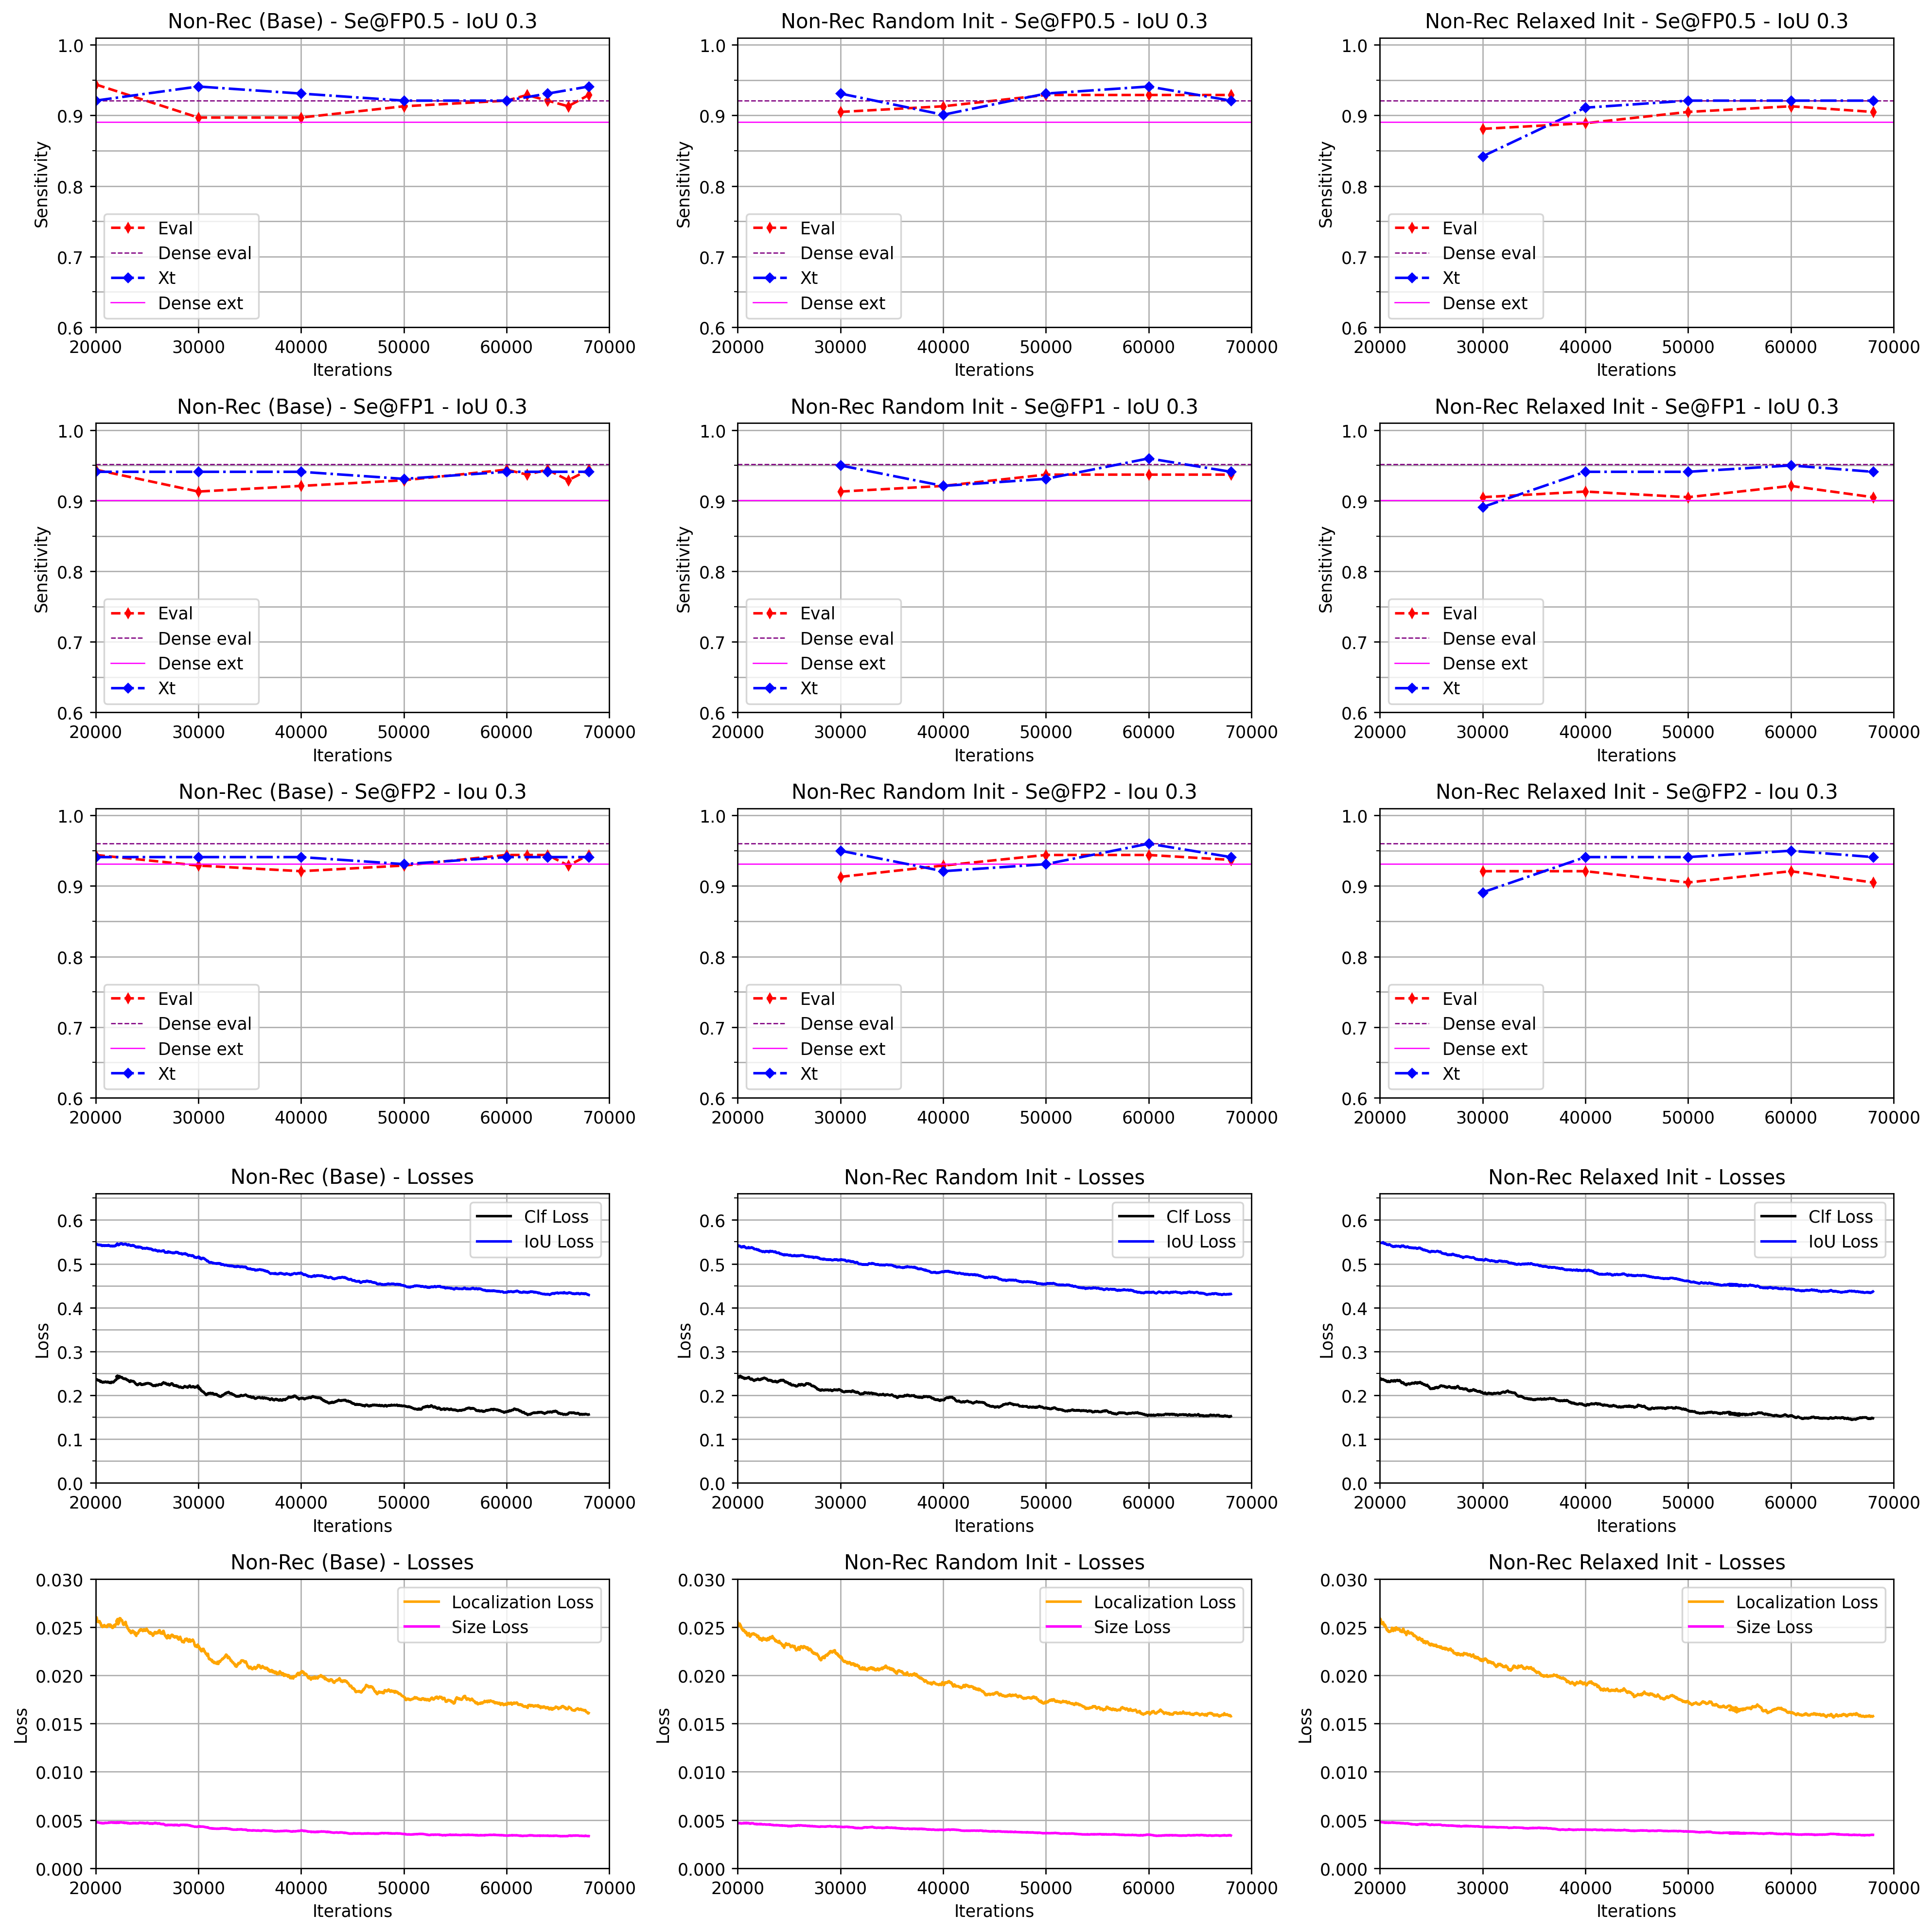

In [16]:
df_all = pd.DataFrame(rows, columns=columns)
iouthr = 0.3
df_all = df_all[df_all["thr"] == iouthr]
exp_is = [
    "deform_decoder_only_non_rec_BEST_cropinf",
    "deform_decoder_only_non_rec_16_heads_random",
    "deform_decoder_only_non_rec_16_heads_relaxed",
]
ti_versions = []
ext_versions = [exp + "_EXT" for exp in exp_is]

plot_all_results(
    df_all,
    dict_metrics,
    exp_is,
    ti_versions,
    ext_versions,
    result_to_plot="Se",
    iouthr=iouthr,
)

In [20]:
non_detect_counts = df_annot[df_annot["detected"] == False]["size"].value_counts()
non_detect_counts["medium"]

18

In [30]:
df_annot["size"].value_counts()

size
medium    84
large     25
small     17
Name: count, dtype: int64

In [35]:
df_viz = pd.DataFrame(rows, columns=columns)
df_viz

,model,viz_name,chptk,thr,Se@FP0.5,Se@FP1,Se@FP2,small_tpr,medium_tpr,large_tpr
0,deform_decoder_only_4_layers,Deform Non-Rec 4 Layers,30k,0.1,0.944,0.960,0.968,0.941176,0.988095,0.96
1,deform_decoder_only_4_layers,Deform Non-Rec 4 Layers,40k,0.1,0.944,0.944,0.960,0.941176,0.964286,1.00
2,deform_decoder_only_4_layers,Deform Non-Rec 4 Layers,50k,0.1,0.929,0.960,0.968,0.941176,0.964286,1.00
3,deform_decoder_only_4_layers,Deform Non-Rec 4 Layers,60k,0.1,0.944,0.952,0.952,1.000000,0.952381,0.96
4,deform_decoder_only_4_layers,Deform Non-Rec 4 Layers,final,0.1,0.937,0.944,0.952,1.000000,0.952381,0.96
5,deform_decoder_only_4_layers,Deform Non-Rec 4 Layers,30k,0.2,0.937,0.944,0.952,0.882353,0.976190,0.96
6,deform_decoder_only_4_layers,Deform Non-Rec 4 Layers,40k,0.2,0.937,0.937,0.944,0.941176,0.940476,0.96
7,deform_decoder_only_4_layers,Deform Non-Rec 4 Layers,50k,0.2,0.929,0.952,0.952,0.941176,0.952381,0.96
8,deform_decoder_only_4_layers,Deform Non-Rec 4 Layers,60k,0.2,0.944,0.952,0.952,1.000000,0.952381,0.96
9,deform_decoder_only_4_layers,Deform Non-Rec 4 Layers,final,0.2,0.937,0.944,0.952,1.000000,0.952381,0.96
